# 050. Logistic Regression

## data: 성별 소득 data 에 따라 특정 구매자의 구매할지 여부를 예측

- Logistric Regrssion 모델 작성
- 편향된 data 의 Precision / Recall 계산
- Confusion Matrix 시각화

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

dataset = pd.read_csv('datasets/Social_Network_Ads.csv')

In [3]:
dataset.tail()

,User ID,Gender,Age,EstimatedSalary,Purchased
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0
399,15594041,Female,49,36000,1


In [4]:
dataset['Purchased'].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

### Age, EstimatedSalary 를 변수로 선택

In [5]:
X = dataset.iloc[:, [2,3]].values.astype("float32")
y = dataset.iloc[:, 4].values.astype("float32")

dataset 을 Training 과 Test set 으로 분리

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Feature Scaling

### train data 로 fit 하고, test data 는 train data 의 분포에 맞추어 transform

In [7]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [8]:
print(X_train.shape)

(320, 2)


### Training set 에 대해 Logistic Regression model 을 fitting

In [9]:
lr_classifier = LogisticRegression(solver='lbfgs', random_state=0)
lr_classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

### predict

- predict() - 예측된 class 를 threshold 0.5 기준으로 반환
- predict_proba() - class 별 probability 를 반환

In [10]:
y_pred = lr_classifier.predict(X_test)

print(y_pred)
print()
print("Test set 의 true counts = ", sum(y_test))
print("모델이 예측한 predicted true counts = ", sum(y_pred))
print("accuracy = {:.2f}".format(sum(y_pred == y_test) / len(y_test)))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 1.]

Test set 의 true counts =  22.0
모델이 예측한 predicted true counts =  18.0
accuracy = 0.93


### class 별 확률

In [11]:
y_pred_proba = lr_classifier.predict_proba(X_test)

print('마지막 5 개 예시 - [0, 1] :\n', y_pred_proba[-5:])
print()
print('마지막 5 개 예시 - 1 일 확률 : \n', y_pred_proba[:,1][-5:])

마지막 5 개 예시 - [0, 1] :
 [[0.98822464 0.01177536]
 [0.46265837 0.53734163]
 [0.69737044 0.30262956]
 [0.29266729 0.70733271]
 [0.11918993 0.88081007]]

마지막 5 개 예시 - 1 일 확률 : 
 [0.01177536 0.53734163 0.30262956 0.70733271 0.88081007]


### Threshold 조정

In [12]:
y_pred_proba_1 = y_pred_proba[:, 1]

THRESHOLD = 0.5
print("Threshold {} 을 기준으로 1 로 분류한 True 갯수 : ".format(THRESHOLD), sum(y_pred_proba_1 > THRESHOLD))

THRESHOLD = 0.9
print("Threshold {} 을 기준으로 1 로 분류한 True 갯수 : ".format(THRESHOLD), sum(y_pred_proba_1 > THRESHOLD))

Threshold 0.5 을 기준으로 1 로 분류한 True 갯수 :  18
Threshold 0.9 을 기준으로 1 로 분류한 True 갯수 :  9


In [13]:
THRESHOLD = 0.5
y_pred = y_pred_proba_1 > THRESHOLD
sum(y_pred)

18

## confusion matrix 를 이용한 model 평가

In [14]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
import seaborn as sns

confution matrix
 [[17  5]
 [ 1 57]]


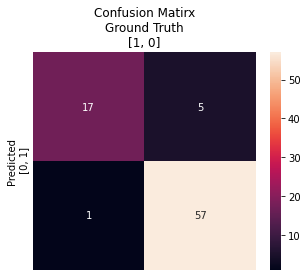

In [15]:
cm  = confusion_matrix(y_test, y_pred, labels=[1, 0])

print("confution matrix\n", cm)

plt.figure(figsize=(5,4))

ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=False, yticklabels=False)
ax.set_ylabel('Predicted\n [0, 1]')
ax.set_title('Confusion Matirx\nGround Truth\n[1, 0]')
None

In [16]:
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred, labels=[1, 0])))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred, labels=[1, 0])))
print("f1 score\n", f1_score(y_test, y_pred))

Accuracy: 0.93
Precision: 0.94
Recall: 0.77
f1 score
 0.85


# 실습 

## Fraud Payment Logistic Regression

- accountAgeDays : 계정이 생성된 기간 (일)
- numItems : 구매한 항목 수
- localTime : 결제가 이루어진 시기 (부동 숫자로 변환 됨)
- paymentMethod : 결제 방법 (페이팔, 상점 신용 카드 또는 신용 카드)
- paymentMethodAgeDays : 결제가 완료된 기간 (일)
- label 0 - 정상, 1 - fraud

In [19]:
df = pd.read_csv("security_data/payment_fraud.csv")
df.sample(5)

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
2166,417,1,4.921349,storecredit,0.000000,0
9006,3,1,3.954522,creditcard,0.000000,0
32731,2,1,4.836982,creditcard,1.978472,0
15249,2000,1,5.034622,creditcard,0.000000,0
390,2000,1,5.040929,creditcard,0.000000,0


In [21]:
df['label'].value_counts()

0    38661
1      560
Name: label, dtype: int64

In [22]:
df['paymentMethod'].value_counts()

creditcard     28004
paypal          9303
storecredit     1914
Name: paymentMethod, dtype: int64

In [23]:
df = pd.get_dummies(df, columns=['paymentMethod'])
df.sample(5)

,accountAgeDays,numItems,localTime,paymentMethodAgeDays,label,paymentMethod_creditcard,paymentMethod_paypal,paymentMethod_storecredit
3627,5,2,5.017904,0.000000,0,1,0,0
28033,248,1,4.836982,63.867361,0,1,0,0
19499,492,1,4.745402,0.000000,0,1,0,0
25261,2000,1,3.575983,190.294444,0,1,0,0
12751,2,1,4.524580,1.789583,0,1,0,0


### Train / Test split

In [24]:
# your code here

### Model 생성

In [25]:
# your code here

### predict

- predict() - 예측된 class 를 threshold 0.5 기준으로 반환
- predict_proba() - class 별 probability 를 반환

In [26]:
# your code here

## confusion matrix 를 이용한 model 평가

In [27]:
# your code here